In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Device configuration
# I am using a Mac M3 chip, so I can't use CUDA, but if you are on nvidia, change this to CUDA
device = torch.device("mps")

In [9]:
# with a large batch size, the optimizer needs a faster learning rate to converge properly. 
num_epochs = 100
batch_size = 600
learning_rate = 0.02

Let's load the KMNIST data set, first we use torch to install the data, then we use transform to preprocess the images. then using torch utilities we load the data into a dataset, and batch it. 

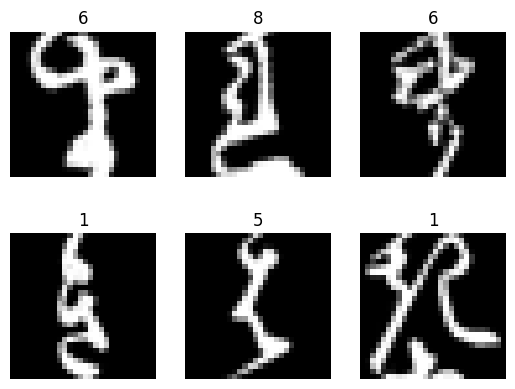

In [10]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# visualize some of the data
examples = iter(train_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(example_targets[i].item())
    plt.axis('off')
    plt.imshow(example_data[i][0], cmap='gray')

Now let's create a simple Convolutional Neural Network, 

I choose two Convolutional layers here, to capture basic concepts of the image, The first layer has 16 filters, and for more complex details, the second layer has 32 filters. Max pooling helps make the images resolution smaller, which lowers the dimensionality to ease computations in the next layer. Then ReLU makes the model learn better by avoiding linearity. The fully connected layers at the end are the output nodes and determine which digit is most likely (0-9). This setup works well for MNIST because the images are small and don't have any color data.

In [11]:
# make a cnn model with 2 convolutional layers and 2 fully connected layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

Here I chose Cross Entropy Loss as the loss function because it is well-suited for multi-class classification problems (like KMNIST), It combines both softmax and the negative log likelihood to provide a stable loss calculation that encourages the network to output high probabilities for the right classes.

I chose RAdam with decoupled weight decay here because of this paper https://arxiv.org/abs/1908.03265

In summary, 

- regular Adam with decoupled weight decay is an improved version of Adam modifies where the weight decay is performed only after controlling the parameter-wise step size, providing better regularization. This helps prevent overfitting and improves generalization.

- Taking this a step further, we can use RAdam that is different by adapting its learning rate warmup mechanism. This leads to better convergence, especially in the early stages of training.

Then, I chose to exponentially decay the Learning rate so that once the model finishes an epoch, the learning rate isn't as high as the model is already mostly trained. 

In [12]:
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % (len(train_loader)//4) == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.6f}')
    scheduler.step()

Epoch [1/100], Step [25/100], Loss: 1.068353
Epoch [1/100], Step [50/100], Loss: 0.514459
Epoch [1/100], Step [75/100], Loss: 0.301247
Epoch [1/100], Step [100/100], Loss: 0.191677
Epoch [2/100], Step [25/100], Loss: 0.147740
Epoch [2/100], Step [50/100], Loss: 0.114495
Epoch [2/100], Step [75/100], Loss: 0.132528
Epoch [2/100], Step [100/100], Loss: 0.120564
Epoch [3/100], Step [25/100], Loss: 0.077716
Epoch [3/100], Step [50/100], Loss: 0.061238
Epoch [3/100], Step [75/100], Loss: 0.078929
Epoch [3/100], Step [100/100], Loss: 0.068393
Epoch [4/100], Step [25/100], Loss: 0.080505
Epoch [4/100], Step [50/100], Loss: 0.041137
Epoch [4/100], Step [75/100], Loss: 0.058307
Epoch [4/100], Step [100/100], Loss: 0.057730
Epoch [5/100], Step [25/100], Loss: 0.013522
Epoch [5/100], Step [50/100], Loss: 0.019379
Epoch [5/100], Step [75/100], Loss: 0.042668
Epoch [5/100], Step [100/100], Loss: 0.052018
Epoch [6/100], Step [25/100], Loss: 0.031090
Epoch [6/100], Step [50/100], Loss: 0.016780
Epoch

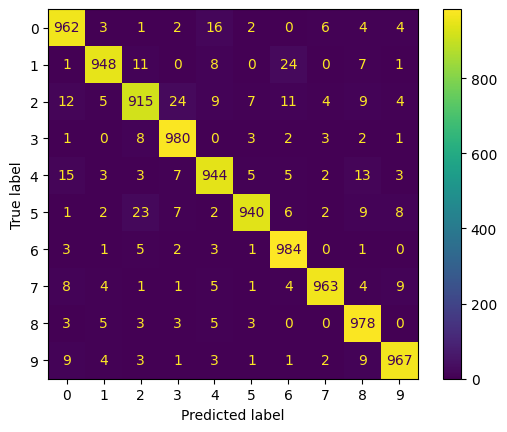

Model Architecture:
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

Model Evaluation:
Accuracy: 0.9581

Hyperparameters:
Learning Rate: 0.02
Batch Size: 600
Number of Epochs: 100


In [13]:
# Evaluation and confusion matrix

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
cm_display.plot()
plt.show()

# Model summary of accuracy and hyperparameters
print("Model Architecture:")
print(model)
print("\nModel Evaluation:")
print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))}")
print("\nHyperparameters:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")



Using the above parameters, I can get a pretty good score (roughly 99.3%) given the histogram of Kaggle scores. In this case, my model seems to be on the higher end of pure CNNs, even though my architecture is pretty simple. I believe that has to do with the optimizers and the learning rate decay, as that helped my model break throguh from 98%. 

Adding a data augmentation step would surely increase my accuracy, perhaps a dropout layer as well to improve regularization, and creating a more complex CNN could also be helpful. But based on the Kaggle score, I probably have reached an inherit limit of pure CNNs. 

According to the paper that currently holds the highest score, https://arxiv.org/pdf/2001.09136v6, using Homogeneous Vector Capsules (HVCs), their simple convolutional network achieves state-of-the-art MNIST classification with fewer parameters, fewer epochs, and without a routing mechanism. Unlike regular neurons, which output a scalar value, capsules output a vector, which contain more information about the properties of a detected entity (like, for example, their presence, orientation, maybe their scale).